<a href="https://colab.research.google.com/github/costacis21/Brain-Tumor-Radiogenomic-Classification/blob/main/test1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install tensorflow-io==0.23.1
%tensorflow_version

!pip install kaggle
!pip install --upgrade --force-reinstall --no-deps kaggle
!mkdir ~/.kaggle
!cp '/content/drive/MyDrive/Colab Notebooks/kaggle.json' ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!pip install python3-wget
import wget
!pip install pydicom


     |████████████████████████████████| 23.1 MB 2.4 MB/s 
     |████████████████████████████████| 2.1 MB 36.3 MB/s 
  Attempting uninstall: tensorflow-io-gcs-filesystem
    Found existing installation: tensorflow-io-gcs-filesystem 0.24.0
    Uninstalling tensorflow-io-gcs-filesystem-0.24.0:
      Successfully uninstalled tensorflow-io-gcs-filesystem-0.24.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
Currently selected TF version: 2.x
Available versions:
* 1.x
* 2.x
     |████████████████████████████████| 58 kB 5.1 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=b540ab2756178d3e4efd8b7c277a324dedc219532ee1675734bb2e47363948b0
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155

In [3]:
#load data from keggle

!mkdir training

url = "https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/29653/2420395/compressed/train.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1647031985&Signature=iK2BUJGdRNR%2BRAG2YBUXDjeLAZ5yGFxIAb6FljAxMmJaI%2FG%2FTLUiKfKCSG9eRtFoZKx87%2FiHMTlaf%2BkIgxLk%2FjjDN565LRC5vyllqirpBVY0LtOWBA8OPJIxk5OgsI%2Bmbv6SizbORm19c4VTENkf9%2FESew6%2FfInnJU7Xct2fPL3fYJjlWtPTGFTK5pEamA2gG%2BAsAfnaffT0NMlYKXY6o2983Il1tA%2B3bwBq0T%2FicgO8Gw2sf5d6rS%2FEt8U8zzY8CBarm%2BXD4nzB7zLfQW0m8PounmnCYHm%2FUh2sXGnqK80vgsfB%2BwBB0%2B9b8bowXsCZC4bLlwxhmXl2pG9KVTskGw%3D%3D&response-content-disposition=attachment%3B+filename%3Dtrain.zip"
wget.download(url,"training/",bar=wget.bar_adaptive)
# !kaggle competitions download -p training/ -c "rsna-miccai-brain-tumor-radiogenomic-classification"

mkdir: cannot create directory ‘training’: File exists


'training//train.zip'

In [ ]:
!kaggle -v

In [ ]:
!unzip training/train.zip -d training/

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_io as tfio
import os
import glob

import pandas as pd
import numpy as np
from pathlib import Path

import random
from tqdm.notebook import tqdm

import pydicom # Handle MRI images

import cv2  # OpenCV - https://docs.opencv.org/master/d6/d00/tutorial_py_root.html

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, log_loss

from scipy import ndimage

from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers

Text(0.5, 1.0, '0002-T2w-image-100')

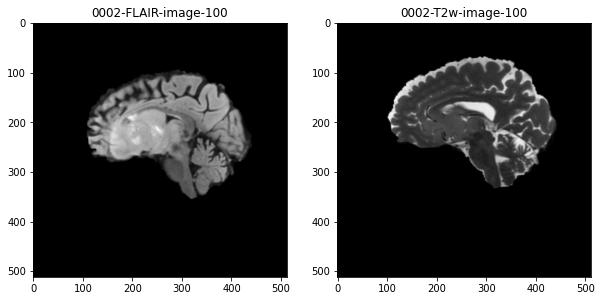

In [6]:
#load two dcm files

image_bytes_1 = tf.io.read_file('training/00002/FLAIR/Image-450.dcm')
image_bytes_2 = tf.io.read_file('training/00002/T2w/Image-200.dcm')

image_1 = tfio.image.decode_dicom_image(image_bytes_1,dtype=tf.uint16)
image_2 = tfio.image.decode_dicom_image(image_bytes_2,dtype=tf.uint16)

fig,axes = plt.subplots(1,2,figsize=(10,10))
axes[0].imshow(np.squeeze(image_1.numpy()),cmap='gray')
axes[0].set_title('0002-FLAIR-image-100')
axes[1].imshow(np.squeeze(image_2.numpy()),cmap='gray')
axes[1].set_title('0002-T2w-image-100')


In [7]:
data_dir = Path('training')

#Read csv file for IDs
mri_types = ["FLAIR", "T1w", "T2w", "T1wCE"]
excluded_images = [109, 123, 709] # Bad images
train_df = pd.read_csv(data_dir / "_labels.csv")

#Remove images with unexpected issues
train_df = train_df[~train_df.BraTS21ID.isin(excluded_images)]

print(f"train data: Rows={train_df.shape[0]}, Columns={train_df.shape[1]}")


train data: Rows=582, Columns=2


In [8]:
def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 64
    desired_width = 128
    desired_height = 128
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img

def load_dicom(path, size = 224):
    dicom = pydicom.read_file(path)
    data = dicom.pixel_array
    if np.max(data) != 0:
        data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return cv2.resize(data, (size, size))

def load_dicom2(path):
    data = np.concatenate([tf.expand_dims(pydicom.read_file(p).pixel_array, axis=-1) for p in path], axis=2)
    if np.max(data) != 0:
        data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return resize_volume(data)



In [12]:
def get_all_image_paths(brats21id, image_type, folder=''):
    assert(image_type in mri_types)
    
    patient_path = os.path.join(folder,
                str(brats21id).zfill(5)
    )
    
    paths = sorted(
        glob.glob(os.path.join(patient_path, image_type, "*"))
    )

    num_images = len(paths)
    start = int(num_images * 0.25)
    end = int(num_images * 0.75)

    interval = 1
    
    return np.array(paths[start:end:interval])

def get_all_images(brats21id, image_type, folder='', size=225):
    return [load_dicom(path, size) for path in get_all_image_paths(brats21id, image_type, folder)]

def get_all_images2(brats21id, image_type, folder=''):
    return [load_dicom2(get_all_image_paths(brats21id, image_type, folder))]

def get_all_data_for_train(image_type='T1wCE'):
    global train_df
    
    X = []
    y = []
    train_ids = []

    for i in tqdm(train_df.index):
        x = train_df.loc[i]
        images = get_all_images2(int(x['BraTS21ID']), image_type, 'training/')
        
        label = x['MGMT_value']

        X += images
        y += [label] * len(images)
        train_ids += [int(x['BraTS21ID'])] * len(images)
        assert(len(X) == len(y))
    return np.array(X), np.array(y), np.array(train_ids)

In [14]:

X, y, trainidt = get_all_data_for_train()


  0%|          | 0/582 [00:00<?, ?it/s]

1


(582, 128, 128, 64)
(128, 128)


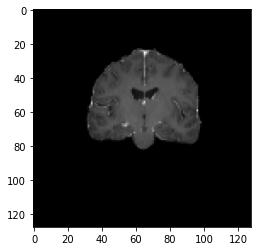

In [72]:
print(X.shape)
data = X[0,:,:,:]
image=data[:,:,56]
print(image.shape)
plt.imshow(np.squeeze(image),cmap="gray")


# list(data)[1].shape
# data = data.take(1)
# images, labels = list(data)[0]
# image = images[0]
# print("Dimension of the CT scan is:", image.shape)
# plt.imshow(np.squeeze(image[:, :, 30]), cmap="gray")

In [78]:
def get_3DCNNmodel(width=128, height=128, depth=64, name='3dcnn'):
    """Build a 3D convolutional neural network model."""

    inputs = tf.keras.Input((width, height, depth, 1))

    x = tf.keras.layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = tf.keras.layers.MaxPool3D(pool_size=2)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = tf.keras.layers.MaxPool3D(pool_size=2)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = tf.keras.layers.MaxPool3D(pool_size=2)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = tf.keras.layers.MaxPool3D(pool_size=2)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.GlobalAveragePooling3D()(x)
    x = tf.keras.layers.Dense(units=512, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    #outputs = tf.keras.layers.Dense(units=1, activation="sigmoid")(x)
    output = keras.layers.Dense(2, activation="sigmoid")(x)

    #model = tf.keras.Model(inputs, outputs, name=name)

    #initial_learning_rate = 0.0001
    #lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    #    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
    #)
    #model.compile(
    #    loss="binary_crossentropy",
    #    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    #    metrics=["acc"],
    #)
    model = keras.Model(inputs, output)
    initial_learning_rate =  0.0001
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=100000,
        decay_rate=0.96, 
        staircase=True
    )
  
    roc_auc = tf.keras.metrics.AUC(name='roc_auc', curve='ROC')

    model.compile(
        loss="binary_crossentropy", 
        optimizer=keras.optimizers.Adam(),
        metrics=[roc_auc],
    )
    return model

In [74]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="val_roc_auc", mode='max', patience=10)


In [ ]:
""" 
function ConnectButton(){
  console.log("Connect pushed"); 
  document.querySelector("#top-toolbar > colab-connectbutton").shadowRoot.querySelector("#connect").click() 
}
setInterval(ConnectButton,60000);
"""

In [79]:
auc_list = []
best_auc = float("-inf")

for i in tqdm(range(20)):
    checkpoint_filepath = "best_model_"+str(i)+".h5"

    model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=False,
        monitor="val_roc_auc",
        mode="max",
        save_best_only=True,
        save_freq="epoch",
        verbose=0,
    )
    X_train, X_valid, y_train, y_valid, trainidt_train, trainidt_valid = train_test_split(X, y, trainidt, test_size=0.2, random_state=i)

    X_train = tf.expand_dims(X_train, axis=-1)
    X_valid = tf.expand_dims(X_valid, axis=-1)
    y_train = to_categorical(y_train)
    y_valid = to_categorical(y_valid)

    model = get_3DCNNmodel()

    history = model.fit(x=X_train, y = y_train, epochs=40, batch_size = 2,
                        callbacks=[model_checkpoint_cb, early_stopping_cb],
                        validation_data=(X_valid, y_valid), verbose=0)

    model_best = tf.keras.models.load_model(filepath=checkpoint_filepath)
    y_pred = model_best.predict(X_valid,batch_size = 2)

    pred = np.argmax(y_pred, axis=1)

    result = pd.DataFrame(trainidt_valid)
    result[1] = pred

    result.columns = ["BraTS21ID", "MGMT_value"]
    result2 = result.groupby("BraTS21ID", as_index=False).mean()

    result2 = result2.merge(train_df, on="BraTS21ID")
    auc = roc_auc_score(
        result2.MGMT_value_y,
        result2.MGMT_value_x,
    )
    print(f"Validation AUC={auc}")
    auc_list.append(auc)
    if auc > best_auc:
        best_i = i
        best_auc = auc

  0%|          | 0/20 [00:00<?, ?it/s]

Validation AUC=0.5993852459016393
Validation AUC=0.5582089552238806
Validation AUC=0.5529891304347827
Validation AUC=0.5592798594847775
Validation AUC=0.616268656716418
Validation AUC=0.5444444444444444
Validation AUC=0.5390350877192982
Validation AUC=0.6407071887784921
Validation AUC=0.5381578947368421
Validation AUC=0.5645636792452831
Validation AUC=0.5918003565062389
Validation AUC=0.606140350877193
Validation AUC=0.4912023460410557
Validation AUC=0.5425438596491228
Validation AUC=0.6165105386416861
Validation AUC=0.5396825396825397
Validation AUC=0.5536236119228521
Validation AUC=0.49166666666666664
Validation AUC=0.5777224824355972
Validation AUC=0.5608955223880596


In [80]:
while true:
  pass


NameError: ignored